<a href="https://colab.research.google.com/github/Drisnor/IA/blob/master/M2_IARF_TP2_etudiant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2 IARF-RODECO TP 2 : classification d'objets dans des images avec un CNN

**Auteurs :** Benjamin Chamand - Thomas Pellegrini

**Année :** 2018

Le cadre de ce TP est de vous montrer et implémenter différentes méthodes d'apprentissage utilisant des réseaux convolutifs dans le cas du traitement des images.

Contrairement au réseau dense que l'on a pu voir à la séance dernière, les réseaux convolutifs s'inspirent du cortex visuel en proposant une architecture sur plusieurs couches qui se spécialisent sur une tâche de plus en plus abstraite, c'est-à-dire que les premières couches vont essayer d'extraire des détails alors que les dernières vont essayer d'extraire des motifs plus généraux.

Les réseaux convolutifs permettent ainsi de proposer un système où les neurones d'une couche sont connectés localement à des neurones de la couche précédente (contraitement au réseau MLP où tous les neurones de  couches bipartites sont interconnectés).

## Gestion des pré-requis avant de commencer le TP

### Importation des bibliothèques

Premièrement, il faut faire les import nécessaires au TP

In [21]:
import os
import requests
import zipfile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt

Comme la semaine dernière, vérifier bien que Keras utilise le GPU pour les calculs.
Si ce n'est pas le cas, il faut aller dans Exéction > Modifier le type d'exécution > Accélérateur Matériel > GPU

In [22]:
if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9142204163579255674
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18226486609601010831
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5549774098800242764
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15623012501629066547
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


### Fixer la seed

On fixe la seed comme la semaine dernière afin de retrouver les mêmes résultats à chaque lancement du programme.

In [23]:
from numpy.random import seed
seed(123) # On peut utiliser n'importe quelle nombre

import tensorflow
tensorflow.random.set_seed(1234) #MAJ 

### Téléchargement du corpus

Tout au lond de la séance d'aujourd'hui, nous allons utiliser un sous-ensemble du dataset *Cats vs Dogs* de Microsoft.
Ce dataset est disponible dans son intégralité (données d'apprentissage, de validation, ainsi que les données de test) sur le site Kaggle en tant que challenge publique.

Comme son nom l'indique, le but de ce challenge est de classifier correctement si oui ou non une image donnée en entrée contient un chien ou un chat, miaou !

![cats_vs_dogs](https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/woof_meow.jpg)

Pour limiter le besoin en mémoire et en temps de calcul, le corpus que l'on va utiliser est constitué seulement des données de tests et de validation que nous utiliserons comme données de tests.

La base de données téléchargée est stockée dans :

```
./data/cats_and_dogs_filtered/
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers*.


In [24]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -P data/
!unzip -qq data/cats_and_dogs_filtered.zip -d data/
!rm data/cats_and_dogs_filtered.zip

--2020-09-23 08:44:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘data/cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   189MB/s    in 0.3s    

2020-09-23 08:44:20 (189 MB/s) - ‘data/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

replace data/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [25]:
base_dir = './data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


#### Affichage

On peut aussi afficher quelques images de la base de données d'apprentissage

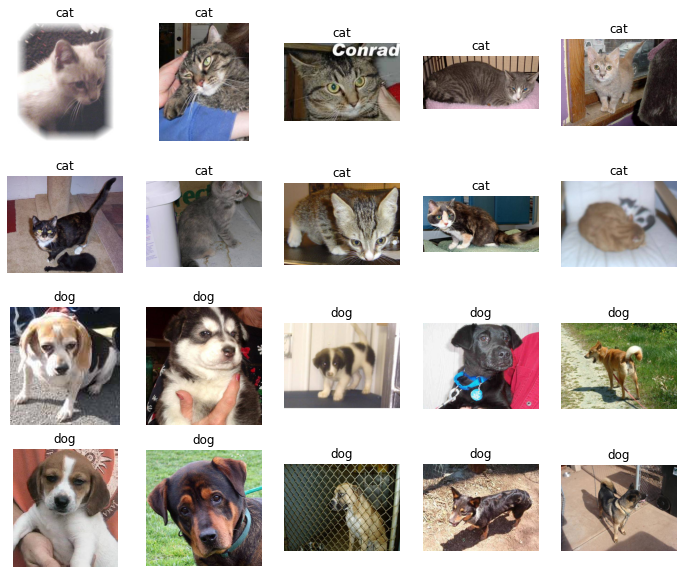

In [26]:
# récupération de 10 images de chats et chiens du corpus
cat_files = [(os.path.join(train_cats_dir, fname), 'cat')
             for i, fname in enumerate(os.listdir(train_cats_dir)) if i < 10]
dog_files = [(os.path.join(train_dogs_dir, fname), 'dog')
             for i, fname in enumerate(os.listdir(train_dogs_dir)) if i < 10]
cat_dog_files = cat_files + dog_files

plt.figure(figsize=(12,10))

for i in range(20):
    # chargement de l'image
    img, target = cat_dog_files[i]
    img = load_img(img)
    # choix de la zone d'affichage et affichage de l'image
    plt.subplot(4,5,i+1)
    plt.imshow(img)
    # ajout d'un titre à l'image    
    plt.title(target)
    plt.axis('off')
              
plt.show()

## Partie I : Utilisation d'un réseau pré-entrainé VGG-16

Dans le domaine du traitement d'images, l'apprentissage d'un nouveau modèle pour une tâche de classification de reconnaissance des formes dans les images est complexe soit par le fait que nous n'avons pas assez de données ( il faut plusieurs gigas de données ) soit par le coût computationnel comme on peut le voir lors des compétitions comme **ILSVRC (ImageNet Large Scale Visual Recognition Challenge)**.

Cette compétion a été initiée à l'univeristé de Stanford et est l'une des plus importante depuis quelques années. Les chercheurs se voient proposer d'analyser plus de 1,2 millions d'images, catégorisées en 1000 classes, et le gagnant est celui qui atteint la meilleure précision de reconnaissance sur les 5 premières classes (top-5).
Cette base de données comporte aujourd'hui plus de 14 millions d'images classées en plusieurs milliers de catégories (avions, voitures, chats, ...).

![Image-Net](https://cdn-images-1.medium.com/max/799/1*tV_6-fK-G3wDs2DrybRgpw.jpeg)

Différentes architectures de réseaux convolutifs ont prouvé leur efficacité par rapport aux méthodes anciennes notamment lors de ce type de compétitions. Chaque architectures disposent de particularités qui les différentient les uns des autres.

Dans notre cas, afin d'entrainer le réseau à détecter des chiens ou des chats, il existe deux façons de s'y prendre :

* **soit nous entrainons un modèle dédié à notre tâche de zéro,** (Partie II du TP);

* **soit nous nous basons sur des modèles existants et entrainés sur des compétitions comme ImageNet, on appelle cela de l'apprentissage par transfert** (Partie I du TP).

On se propose donc dans cette première partie du TP d'entraîner un modèle à partir d'un modèle existant.

Pour cela, **Keras propose dans sa bibliothèque de nombreux modèles pré-entrainés sur ImageNet et disponibles dans [Keras Application](https://keras.io/applications/)**.

On va utiliser l'un de ces modèles les plus célèbres et très simples d'un point de vue architecture du réseau qui se nomme **VGG-16**. Les réseaux VGG (Visual Geometry Group, université d'Oxford) ont été les premiers à utiliser des petits filtres de convolutions de taille (3x3) et à les combiner.

![architecture VGG-16](https://qph.fs.quoracdn.net/main-qimg-ba81c87204be1a5d11d64a464bca39eb)


### Importation du modèle

Importons le modèle **VGG16**, ainsi que la fonction **preprocess_input** permettant de réaliser les même pré-traitements qui ont servi à entrainer le modèle initiale. Cette fonction est importante car nous devons avoir le même format de données pour pouvoir utiliser le modèle.

In [27]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

Visualisons l'architecture du réseau

In [28]:
VGG16().summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Chargement des données

Pour cette première partie, nous proposerons la classe suivante afin de charger les données correctement en mémoire.
Contrairement au TP de la séance précédente où toutes les données étaient déjà chargés en mémoire, il faut, dans notre cas, charger les images dans la mémoire par batch et non charger l'intégralité de nos données (problème de mémoire sinon). 

Cette classe hérite de la classe **Sequence de Keras** qui permet de définir notre stratégie de chargement des données, la taille des batchs, les pré-traitements, les traitements entre chaque epoch, etc.

Cette classe nous renvoie un générateur en python, donc par la suite, il faudra utiliser les méthodes **fit_generator**, **evaluate_generator** et **predict_generator** au lieu de **fit**, **evaluate** et **predict** vus à la précédente séance.

In [29]:
class DogsVSCats(keras.utils.Sequence):
    splits = {'train': 'train',
              'test': 'validation'}

    def __init__(self, root, split='train', shuffle=False, target_size=(224,224), batch_size=32):
        if split not in self.splits:
            raise ValueError('Split "{}" not found. Valid splits are: {}'.format(
                split, ', '.join(self.splits.keys())))

        self.root = os.path.expanduser(root)
        self.split = split
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if not self._check_exists():
            raise RuntimeError('Dataset not found or corrupted.')

        # load dataset informations
        self.classes = ['cats', 'dogs']
        self.samples, self.labels = self._make_dataset()
        
        self.on_epoch_end()

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # generate data
        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size))
        
        for i, idx in enumerate(indexes):
            img, target = self.samples[idx], self.labels[idx]
            img = load_img(img, target_size=self.target_size)
            X[i] = preprocess_input(img_to_array(img))
            y[i] = target          
        return X, y

    def __len__(self):
        return int(np.floor(len(self.samples) / self.batch_size))
    
    def _check_exists(self):
        return all(os.path.isdir(os.path.join(self.root, split)) for split in self.splits.values())
    
    def _make_dataset(self):
        urls = []
        labels = []
        data_dir = os.path.join(self.root, self.splits[self.split])
        extensions = ['.jpg', '.JPG', 'jpeg', '.JPEG']
        # create dataset for a specific part of a dataset
        for idx, class_id in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_id)
            for entry in os.scandir(class_dir):
                # check if the file is valid
                if (entry.is_file() and not entry.name.startswith('.')
                        and any(entry.name.endswith(ext) for ext in extensions)):
                    urls.append(entry.path)
                    labels.append(idx)
        return urls, labels
        
    def on_epoch_end(self):
        """
        Modify your dataset between epochs
        """
        self.indexes = np.arange(len(self.samples))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### Apprentissage par transfert

La méthode d'apprentissage par transfert ou *transfer learning* en anglais se divise en 3 scénarios que l'on veut implémenter dans la suite :
* utiliser le réseau pré-entrainé pour prédire nos données ;
* utiliser le réseau pré-entrainé pour extraire une nouvelle représentation de données et entrainer un nouveau classifieur comme un MLP par exemple vu au TP1 ;
* ré-entrainer un réseau pré-entrainé (**fine-tuning**).

#### Utilisation d'un réseau pré-entrainé

La méthode la plus simple et la plus naives consiste à charger notre modèle VGG16 et analyser la sortie produite sur quelques images de notre corpus.


In [30]:
# Taille des images à respecter pour alimenter le modèle VGG16 déjà défini et entrainé
im_height, im_width = 224, 224
n_channels = 3

Sélection de quelques images issues du corpus de votre choix

In [31]:
# liste de chemin des images
imgs_path = ['data/cats_and_dogs_filtered/validation/cats/cat.2000.jpg',
             'data/cats_and_dogs_filtered/validation/cats/cat.2001.jpg',
             'data/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg',
             'data/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg']

# liste des labels associés à chacune des images définis dans la liste précédente
imgs_label = [img.split('/')[-2] for img in imgs_path]

Chargement des images dans un tableau numpy.

Afin de charger les images, on peut s'aider de la fonction **load_img** qui prend en argument le chemin de l'image à charger en mémoire et la taille de l'image si on veut la redimensionner : *load_img(path, target_size=(...))*

In [32]:
imgs = [img_to_array(load_img(img_path, target_size=(im_height, im_width)))
            for img_path in imgs_path]
imgs = np.stack(imgs, axis=0)

Affichons les images

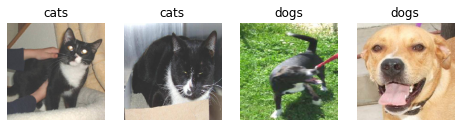

In [33]:
plt.figure(figsize=(len(imgs)*2,2))

for i in range(len(imgs)):
    plt.subplot(1,len(imgs),i+1)
    plt.imshow(imgs[i].astype(np.uint8), vmin=0, vmax=255)
    plt.title(imgs_label[i])
    plt.axis('off')

plt.show()

On va maintenant appliquer les pré-traitements qui ont été réalisés sur la base de données initiales pour l'apprentissage du modèle VGG-16 à l'aide de la fonction **preprocess_input** qui prend en argument une image matricielle.

In [34]:
imgs_preprocess = np.empty_like(imgs)
for i, img in enumerate(imgs):
    imgs_preprocess[i] = preprocess_input(img)

Il reste plus qu'à charger le modèle VGG16 pré-entrainé sur ImageNet

In [35]:
# load the VGG model
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Et on peut maintenant réaliser les prédictions de nos images chargées par ce modèle.

In [40]:
predictions = VGG16().predict_generator(imgs_preprocess)

Affichage des prédictions

In [41]:
print('TOP3 des meilleurs prédictions sur chaque image')
for idx, img_predictions in enumerate(decode_predictions(predictions, top=3)):
    print('\n• image{} ({}):'.format(idx, imgs_label[idx]))
    for i, prediction in enumerate(img_predictions):
        print('\t{} : {} \t- score : {}'.format(i, prediction[1], prediction[2]))

TOP3 des meilleurs prédictions sur chaque image

• image0 (cats):
	0 : Egyptian_cat 	- score : 0.3632001280784607
	1 : Siamese_cat 	- score : 0.16058360040187836
	2 : paper_towel 	- score : 0.05935409665107727

• image1 (cats):
	0 : carton 	- score : 0.27845537662506104
	1 : dishwasher 	- score : 0.09049178659915924
	2 : radiator 	- score : 0.07048556208610535

• image2 (dogs):
	0 : black_stork 	- score : 0.215240016579628
	1 : white_stork 	- score : 0.06754148751497269
	2 : American_Staffordshire_terrier 	- score : 0.06449643522500992

• image3 (dogs):
	0 : Labrador_retriever 	- score : 0.5410293340682983
	1 : kelpie 	- score : 0.08212852478027344
	2 : American_Staffordshire_terrier 	- score : 0.05852251499891281


#### ConvNet comme un extracteur de paramètres

L'avantage de la méthode précédente est de récupérer un modèle déjà existant et de réaliser seulement nos prédictions. Cependant, comme vous avez pu le remarquer, le réseau nous propose 1000 classes différentes qui ne sont pas forcément utile pour notre application.

Il existe une deuxième méthode d'apprentissage par transfert qui consiste à utiliser le modèle entrainé comme un extracteur de nouvelles représentations et ces nouvelles caractéristiques vont servir à alimenter un nouveau classifieur.

Si vous regardez le détail de l'architecture d'un réseau convolutif, vous voyez qu'il y a 2 parties : 
* la première partie consiste à extraire des paramètres à l'aide des convolutions ;
* la seconde partie permet de classifier à l'aide des couches denses.

On va donc garder que la partie convolutive de VGG16 et supprimer le classifieur.
De plus, comme nous supprimons la partie classifieur, on peut redimensionner les images d'entrée dans n'importe quelle dimension, cela ne posera pas de problèmes pour calculer les convolutions, les filtres parcourant l'intégralité de l'image. La taille des images d'entrée devra être spécifiées obligatoirement si on enlève la partie classifieur dans Keras.

Afin de limiter les calculs, réduisons nos images à une taille de (150x150)

In [42]:
im_width, im_height = 150, 150
n_channels = 3

Chargement de VGG16 comme un extracteur de caractéristiques. Attention à bien préciser la taille d'entrée des images !

In [45]:
feature_extractor = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(im_width,im_height,n_channels),
    pooling=None)

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

On va récupérer les caractéristiques pour nos données d'apprentissage et de tests.

Pour cela :
1. Charger les données d'apprentissage et de test via la classe défini plus haut : **DogsVSCats(...)** ;
2. Laisser l'agurment *shuffle* à *False* pour faciliter la récupération des labels ;
3. Utiliser la méthode **[predict_generator](https://keras.io/models/sequential/)** de l'extracteur défini précédemment afin récupérer les nouvelles représentation des données d'apprentissage et de test (afin daccélérer les calculs et gérer l'affichage, on pourra définir le nombre de workers, mettre verbose à 1, etc...) ;
4. Récupérer les labels des données d'apprentissage et de test via l'argument **labels** défini dans la classe **DogsVSCats**. Attention, il faut garder que les $n$ premiers labels avec $n$ qui est le nombre total de features extraites aussi bien en apprentissage qu'en test.

In [46]:
train_generator = DogsVSCats('./data/cats_and_dogs_filtered')
test_generator = DogsVSCats('./data/cats_and_dogs_filtered', split='test')

In [48]:
# caractéristiques et labels des données d'apprentissage
train_features = feature_extractor.predict_generator(train_generator)

train_labels = np.array(train_generator.labels[:train_features.shape[0]])

# caractéristiques et labels des données de test
test_features = feature_extractor.predict_generator(test_generator)

test_labels = np.array(test_generator.labels[:test_features.shape[0]])

On va maintenant définir un nouveau classifieur comme par exemple un simple classifieur à un neurone.

Pour cela, on va procéder de la manière suivante :
1. Afficher la taille du tenseur contenant les caractéristiques ;
2. Transformer le tenseur caractéristique des images pour qu'il y ait un vecteur caractéristiques par image (en d'autres mot, il faut faire un *flatten*) ;
3. Définir le modèle de classifieur  à un neurone et l'entrainer ;
4. Et l'évaluer.

In [49]:
# taille de la matrice caractéristiques des données d'apprentissage
print(train_features.shape)

# taille de la matrice caractéristiques des données de test
print(test_features.shape)

(1984, 7, 7, 512)
(992, 7, 7, 512)


In [50]:
# récupération de la taille de sortie de l'extracteur de paramètres
output_size_train = train_features.shape
output_size_test = test_features.shape
new_size_train = (output_size_train[0],output_size_train[1]*output_size_train[2]*output_size_train[3])
new_size_test = (output_size_test[0], new_size_train[1])

# faire le flatten sur la matrice caractéristiques des données d'apprentissage et de test
train_features_A = train_features.reshape(new_size_train)
test_features_B = test_features.reshape(new_size_test)

# vérification de la taille
print(train_features_A.shape)
print(test_features_B.shape)

(1984, 25088)
(992, 25088)


In [66]:
# définition du modèle de la régression linéaire
model = keras.Sequential([keras.layers.Dense(1, activation='sigmoid',input_shape=train_features_A.shape)])

# affichage du modèle
model.summary()

# compilation du modèle en choisissant la bonne fonction de perte et l'optimiseur
model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1984, 1)           25089     
Total params: 25,089
Trainable params: 25,089
Non-trainable params: 0
_________________________________________________________________


In [67]:
# apprentissage du modèle linéaire
history = model.fit(train_features_A,train_labels,epochs=10)

Epoch 1/10
62/62 [==============================] - 0s 3ms/step - loss: 1.1974 - accuracy: 0.9425
Epoch 2/10
62/62 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9884
Epoch 3/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0409 - accuracy: 0.9955
Epoch 4/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 0.9955
Epoch 5/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9975
Epoch 6/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0556 - accuracy: 0.9965
Epoch 7/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 0.9985
Epoch 8/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.9990
Epoch 9/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9965
Epoch 10/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.9985


In [68]:
# évaluation du modèle avec les données de test
scores = model.evaluate(test_features_B,test_labels)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

31/31 [==============================] - 0s 2ms/step - loss: 0.8415 - accuracy: 0.9778
accuracy: 97.78%


On peut afficher aussi les courbes issues de l'historique d'apprentissage

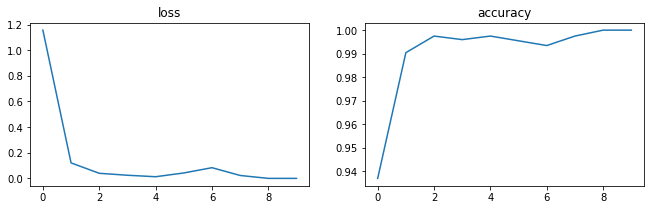

In [62]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

#### Fine tuning

Cette méthode est similaire à la méthode précédente dû fait que l'on définit un nouveau modèle qui a pour base un modèle déjà pré-entrainé auquel on peut rajouter de nouvelles couches de convolutions et une partie classifieur.

La différence se situe sur le fait que l'on peut geler les poids de certaines couches du modèle de base et entrainer les autres afin que le réseau converge un peu plus sur notre corpus d'apprentissage. On peut aussi mettre des taux d'apprentissage sur chaque couche. Lidée étant de simplement ré-entrainer un modèle déjà entrainé.

Dans notre cas, on va simplement réaliser les étapes suivantes :
1. Charger les données d'apprentissage et de test comme précédement en utilisant la classe **DogsVSCats** ;
2. Définir un modèle de base (VGG16) comme précédemment ;
3. Afficher toutes les couches du modèles de bases et bloquer tous les poids avant le 4ème bloque de convolutions. Ce que j'appelle bloque de convolutions, c'est le regroupement de plusieurs couches de convolutions qui se terminent par un *pooling*. Pour geler les couches, rien de plus simple, les classes représentant des modèles sous Keras dispose d'un argument **layers** qui est une liste de toutes les couches (**layer**), on peut ensuite sélectionner un  **layer** dans cette et initialiser son argument **trainable** *False* si on veut geler sinon *True* (voir la documentation de Keras sur le [fine-tune](https://keras.io/applications/));
4. Crée un nouveau modèle qui contient notre modèle de base ainsi qu'un classifieur MLP et l'entrainer en utilisant la méthode **fit_generator** (comme la méthode **predict_generator** vue précédemment, il est possible d'ajouter des arguments à la fonction afin d'accélérer les vitesses de calculs) et SGD comme optimizer avec un taux d'apprentissage (*learning rate*) bas ;

In [69]:
im_width, im_height = 150, 150
n_channels = 3

In [94]:
# charger les données
train_generator = DogsVSCats('./data/cats_and_dogs_filtered', target_size = (150, 150))
test_generator = DogsVSCats('./data/cats_and_dogs_filtered', target_size = (150, 150), split='test')

In [95]:
# chargement du modèle de base sans la partie classifieur
base_model = feature_extractor


In [96]:
# affichage de toutes les couches du modèles de base avec son index associé
for i, layer in enumerate(base_model.layers):
    print(i,layer.name)

for i, layer in enumerate(base_model.layers[1:10]):
    layer.trainable = False

0 input_10
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [108]:
# définition du modèle
model = Sequential()
model.add(base_model)

# a compléter avec les couches supplémentaires :
model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# on va utiliser l'optimiseur SGD qui réalise simplement une descente de gradient
# sans utiliser un taux d'apprentissage dynamique.

from keras.optimizers import SGD
optim = SGD(1e-4, momentum=0.9)
model.compile(optimizer=optim, loss='bce',  metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 1025      
Total params: 23,105,345
Trainable params: 21,369,857
Non-trainable params: 1,735,488
_________________________________________________________________


In [109]:
# apprentissage sur 5 epochs 
history = model.fit(train_generator, 
                    epochs=5)

Epoch 1/5
62/62 [==============================] - 8s 128ms/step - loss: 0.1975 - accuracy: 0.9405
Epoch 2/5
62/62 [==============================] - 8s 127ms/step - loss: 0.0296 - accuracy: 0.9899
Epoch 3/5
62/62 [==============================] - 8s 126ms/step - loss: 0.0101 - accuracy: 0.9980
Epoch 4/5
62/62 [==============================] - 8s 127ms/step - loss: 0.0033 - accuracy: 0.9995
Epoch 5/5
62/62 [==============================] - 8s 128ms/step - loss: 0.0019 - accuracy: 1.0000


In [107]:
scores = model.evaluate_generator(test_generator)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 96.17%


### Petit résumé sur l'apprentissage par transfert

Les premières couches des réseaux convolutifs ont la qualité d'extraire des caractéristiques plus génériques et plus spécifiques aux ensembles de données dans les couches ultérieures.

Dans le domaine de l'apprentissage par transfert, on se retrouve dans 4 scénarios possibles :

1. **Le corpus que l'on dispose est de petite taille et son contenu est semblable à celui du corpus original** qui a servi à entrainer le modèle de base. Il n'est donc pas recommandé d'affiner le réseau avec du fine tuning par exemple à cause du sur-apprentissage. Dans ce cas, il est conseillé **d'extraire les caractéristiques** et d'entrainer simplement un **classifieur linéaire**.

2. **Le nouveau corpus est relativement volumineux et son contenu est semblable à celui de l'ensemble de données original**, on peut donc procéder à du **fine-tuning** afin d'avoir une meilleur confiance en notre réseau de base sans craindre le sur apprentissage.

3. **Le corpus est plus petit en taille, mais son contenu est très différent de celui de l'ensemble de données original**, alors il est possible d'utiliser les **premières couches d'un réseau pré-entrainé** et **d'extraire des caractéristiques** de notre nouveau corpus. Les premières couches d'un réseau convolutif servent simplement à extraire des détails et ne généralisent pas encore les concepts. On peut ensuite utiliser un **classifieur linéaire**.

4. **Le nouvel ensemble de données est de taille relativement importante et son contenu est très différent de celui de l'ensemble de données original**. Pour cela on peut entrainer un **nouveau réseau convolutif depuis zéro**. Il est cependant possible en pratique d'initialiser les poids d'un réseau avec celui d'un réseau déjà entrainé.

## Partie II : Définition de notre modèle CNN

Vous avez pu voir précédemment comment il était possible d'obtenir des bons résultats sur nos données en utilisant un modèle pré-entrainé.

Dans cette seconde partie du TP, vous allez vous même définir un nouveau réseau depuis zéro et comparer vos résultats avec les résultats précédemments.

### Augmentation de données et chargement des données

Introduisons un nouveau concept. Précédemment nous avons entrainé un réseau en l'alimentant par notre corpus de données. 
Cependant, si nous présentons toujours les même données à notre réseau, il va avoir tendance à sur apprendre, c'est-à-dire qu'il va non plus généraliser les données d'apprentissage mais se spécialiser à nos données d'apprentissage. Ce qui est mauvais car nous aurons des mauvais scores sur nos données de test.

Il existe une méthode qui s'appelle **l'augmentation de données** qui consiste à créer des transformations simples sur nos images, sans détériorer le concept, durant l'apprentissage afin que le réseau n'ait jamais les même images. On peut par exemple appliquer des changements de couleurs sur l'image, augmenter le contraste, générer des rotations, des translations, etc..

Pour cela, Keras définit la classe **[ImageDataGenerator](https://keras.io/preprocessing/image/)**.

De plus, contrairement à la partie précédente où nous avons utilisé une classe génératrice définie à la main, **ImageDataGenerator** dispose de méthodes pour charger toutes les images d'un corpus depuis un dossier : **flow_from_directory**.

In [110]:
# définition du chemin du corpus d'apprentissage et de test
base_dir = './data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

In [111]:
# définition des tailles des images
im_width, im_height = 150, 150
n_channels = 3

In [123]:
train_datagen = ImageDataGenerator(rescale=None,
                                   shear_range=30.0,
                                   zoom_range=5)

# en rajouter d'autres ?
test_datagen = ImageDataGenerator(rescale=None,
                                   shear_range=30.0,
                                   zoom_range=5)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(im_height, im_width),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(im_height, im_width),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Création et apprentissage du modèle

Comme dans la séance précédente, sauf que vous pouvez utiliser en plus l'opérateur **Conv2D** et **MaxPooling** de Keras (voir documentation pour plus de détails).

In [124]:
# défintion du modèle
model = Sequential()

# Features extraction
model.add(keras.Input(shape=(im_width, im_height, n_channels)))
model.add(Conv2D(32, 5, strides=2, activation="relu"))
model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D(3))
model.add(Conv2D(32, 3, activation="relu"))
model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D(3))
model.add(Conv2D(32, 3, activation="relu"))
model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D(2))

# MLP
model.add(Flatten())
model.add(Dense(units=32, activation='softmax'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# compiler le modèle
model.compile(optimizer=optim, loss='bce',  metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 32)        2432      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 19, 19, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 32)        

In [125]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=test_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
100/100 - 22s - loss: 0.6937 - accuracy: 0.5045 - val_loss: 0.6953 - val_accuracy: 0.4940
Epoch 2/15
100/100 - 21s - loss: 0.6917 - accuracy: 0.5120 - val_loss: 0.6912 - val_accuracy: 0.5310
Epoch 3/15
100/100 - 22s - loss: 0.6920 - accuracy: 0.5135 - val_loss: 0.6912 - val_accuracy: 0.5360
Epoch 4/15
100/100 - 22s - loss: 0.6905 - accuracy: 0.5365 - val_loss: 0.6892 - val_accuracy: 0.5390
Epoch 5/15
100/100 - 21s - loss: 0.6899 - accuracy: 0.5290 - val_loss: 0.6891 - val_accuracy: 0.5520
Epoch 6/15
100/100 - 22s - loss: 0.6902 - accuracy: 0.5320 - val_loss: 0.6920 - val_accuracy: 0.5330
Epoch 7/15
100/100 - 22s - loss: 0.6896 - accuracy: 0.5350 - val_loss: 0.6917 - val_accuracy: 0.5260
Epoch 8/15
100/100 - 22s - loss: 0.6879 - accuracy: 0.5400 - val_loss: 0.6922 - val_accuracy: 0.5160
Epoch 9/15
100/100 - 22s - loss: 0.6871 - accuracy: 0.5520 - val_loss: 0.6865 - val_accuracy: 0.5650
Epoch 10/15
100/100 - 22s - loss: 0.6880 - accuracy: 0.5340 - val_loss: 0.6856 - val_accura

### (Optionnel) Visualisation des cartes de convolutions

Afficher les cartes de convolutions de chaque layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


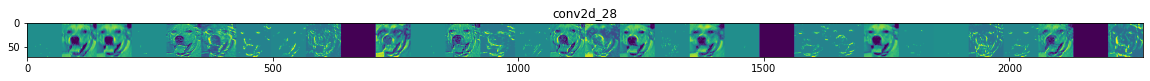

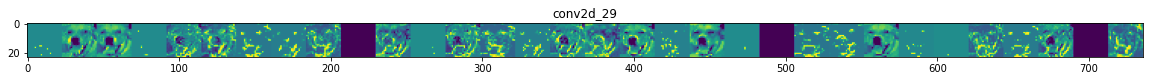

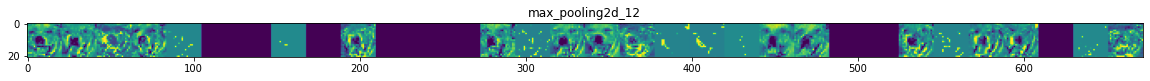

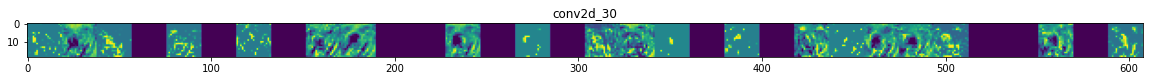

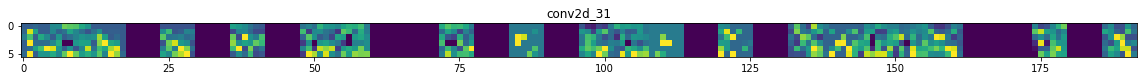

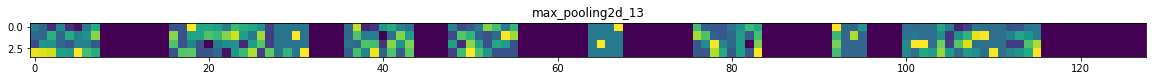

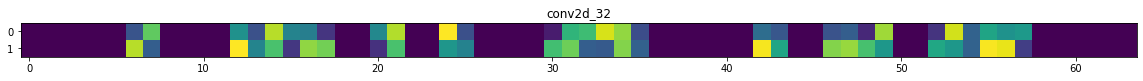

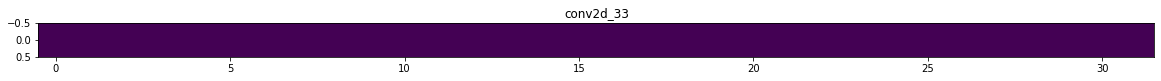

In [126]:
img_path = 'data/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg'
img = load_img(img_path, target_size=(im_height, im_width))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255

# sortie de chaque couche
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = keras.Model(model.input, successive_outputs)

# obtention de toutes sorties alternatives
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()